# **KITTI 3D Object Detection &rarr; LiDAR-Camera Fusion**

In this tutorial we will dive into the KITTI dataset and detect objects in 3D using Early Sensor or Early Fusion which aims to fuse raw data from multiple sources and then perform detection. Late fusion on the other hand involves first detecting objects, and then fusing the detections. In this case we will perform a modified fusion, where we detect objects in the camera images and then fuse their centers with the LiDAR data to get depth.

The main steps are summarized as:

- Detect objects in the camera images (Detection)
- Project 3D LiDAR point clouds to 2D Image space (Fusion)
- Associate LiDAR depth with each Detected object (Association to get Depth)

Detection in 3D as opposed to 2D is much more useful to an autonomous vehicle since 3D detection allows the system know where objects are physically located in the world.

In [1]:
!wget https://s3.eu-central-1.amazonaws.com/avg-kitti/raw_data/2011_10_03_drive_0047/2011_10_03_drive_0047_sync.zip

--2024-05-08 21:36:01--  https://s3.eu-central-1.amazonaws.com/avg-kitti/raw_data/2011_10_03_drive_0047/2011_10_03_drive_0047_sync.zip
Resolving s3.eu-central-1.amazonaws.com (s3.eu-central-1.amazonaws.com)... 3.5.134.195, 52.219.171.193, 52.219.170.5, ...
Connecting to s3.eu-central-1.amazonaws.com (s3.eu-central-1.amazonaws.com)|3.5.134.195|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3103291675 (2.9G) [application/zip]
Saving to: ‘2011_10_03_drive_0047_sync.zip’

2011_10_03_drive_00 100%[===================>]   2.89G  12.4MB/s    in 4m 15s  

2024-05-08 21:40:17 (11.6 MB/s) - ‘2011_10_03_drive_0047_sync.zip’ saved [3103291675/3103291675]



In [2]:
!wget https://s3.eu-central-1.amazonaws.com/avg-kitti/raw_data/2011_10_03_calib.zip

--2024-05-08 21:40:43--  https://s3.eu-central-1.amazonaws.com/avg-kitti/raw_data/2011_10_03_calib.zip
Resolving s3.eu-central-1.amazonaws.com (s3.eu-central-1.amazonaws.com)... 3.5.137.122, 3.5.135.10, 52.219.208.5, ...
Connecting to s3.eu-central-1.amazonaws.com (s3.eu-central-1.amazonaws.com)|3.5.137.122|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4075 (4.0K) [application/zip]
Saving to: ‘2011_10_03_calib.zip’

2011_10_03_calib.zi 100%[===================>]   3.98K  --.-KB/s    in 0s      

2024-05-08 21:40:44 (232 MB/s) - ‘2011_10_03_calib.zip’ saved [4075/4075]



In [3]:
!jar xf 2011_10_03_drive_0047_sync.zip
!jar xf 2011_10_03_calib.zip

## Importing Important Library

In [9]:
import os
from glob import glob
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams["figure.figsize"] = (20, 10)

### Upload utility file named "kitti_utils.py" into local environment

In [10]:
from kitti_utils import *

## Data Overview

In the KITTI raw dataset we get images from four cameras (two grayscale and two RGB), the velodyne LiDAR, and the OXTS GPS navigation system.

The update rates are as follows:
- RGB camera: 15 Hz (15 fps)
- Velodyne LiDAR: 10Hz

The data is synched to the LiDAR, since it has the lowest update rate, but the sync between the camera and LiDAR is not precise (even though we are using the synched raw data!). Per the KITTI the worst time difference between the camera/velodyne is at most 5ms.

In [11]:
DATA_PATH = r'2011_10_03/2011_10_03_drive_0047_sync'

# get RGB camera data
left_image_paths = sorted(glob(os.path.join(DATA_PATH, 'image_02/data/*.png')))
right_image_paths = sorted(glob(os.path.join(DATA_PATH, 'image_03/data/*.png')))

# get LiDAR data
bin_paths = sorted(glob(os.path.join(DATA_PATH, 'velodyne_points/data/*.bin')))

# get GPS/IMU data
oxts_paths = sorted(glob(os.path.join(DATA_PATH, r'oxts/data**/*.txt')))

print(f"Number of left images: {len(left_image_paths)}")
print(f"Number of right images: {len(right_image_paths)}")
print(f"Number of LiDAR point clouds: {len(bin_paths)}")
print(f"Number of GPS/IMU frames: {len(oxts_paths)}")

Number of left images: 837
Number of right images: 837
Number of LiDAR point clouds: 837
Number of GPS/IMU frames: 837


# Generate Video from Kitti-Images

In [12]:
import os
from datetime import datetime

def calculate_fps(image_folder, timestamp_file):
    timestamps = []
    images = [img for img in os.listdir(image_folder) if img.endswith(".png")]

    with open(timestamp_file, 'r') as file:
        for line in file:
            timestamp_str = line.strip()
            # Extract microseconds (last three digits) separately
            timestamp_without_micro = timestamp_str[:-3]
            microseconds = int(timestamp_str[-3:])
            # Parse timestamp up to microseconds
            timestamp = datetime.strptime(timestamp_without_micro, '%Y-%m-%d %H:%M:%S.%f')
            # Add microseconds to the parsed timestamp
            timestamp = timestamp.replace(microsecond=microseconds)
            timestamps.append(timestamp)

    # Calculate average time difference between consecutive frames
    time_diffs = [(timestamps[i] - timestamps[i-1]).total_seconds() for i in range(1, len(timestamps))]
    avg_time_diff = sum(time_diffs) / len(time_diffs)

    # Calculate fps
    fps = int(1 / avg_time_diff)
    return fps

In [8]:
# Specify the folder containing the images
image_folder = '/content/2011_10_03/2011_10_03_drive_0047_sync/image_02/data'

# Specify the path to the timestamp file
timestamp_file = '/content/2011_10_03/2011_10_03_drive_0047_sync/image_02/timestamps.txt'

# Calculate fps
fps = calculate_fps(image_folder, timestamp_file)
print("Estimated FPS:", fps)

Estimated FPS: 9


In [9]:
def create_video_from_images(image_folder, output_video_path, fps=9):
    images = [img for img in os.listdir(image_folder) if img.endswith(".png")]

    # Sort images based on their filenames
    images.sort()

    frame = cv2.imread(os.path.join(image_folder, images[0]))
    height, width, layers = frame.shape

    video = cv2.VideoWriter(output_video_path, cv2.VideoWriter_fourcc(*'mp4v'), fps, (width, height))

    for image in images:
        video.write(cv2.imread(os.path.join(image_folder, image)))

    cv2.destroyAllWindows()
    video.release()

# Specify the folder containing the images and the output video path
image_folder = '/content/2011_10_03/2011_10_03_drive_0047_sync/image_02/data'
output_video_path = '/content/kitti_video.mp4'

# Specify the frame rate (fps) of the output video
fps = 9

create_video_from_images(image_folder, output_video_path, fps)

## **Camera/LiDAR Data**

In order to obtain an understanding of the code to follow, it will help to cover the different reference frames that we will be working with and how we can convert between them. The Camera, LiDAR are located at different positions on the vehicle and all have different reference frames. In autonomous research, the main vehicle that is collecting perception data (camera/LiDAR) is usually called the ego vehicle.

- camera
  - x &#8594; right
  - y &#8594; down
  - z &#8594; forward
- LiDAR
  - x &#8594; forward
  - y &#8594; left
  - z &#8594; up


  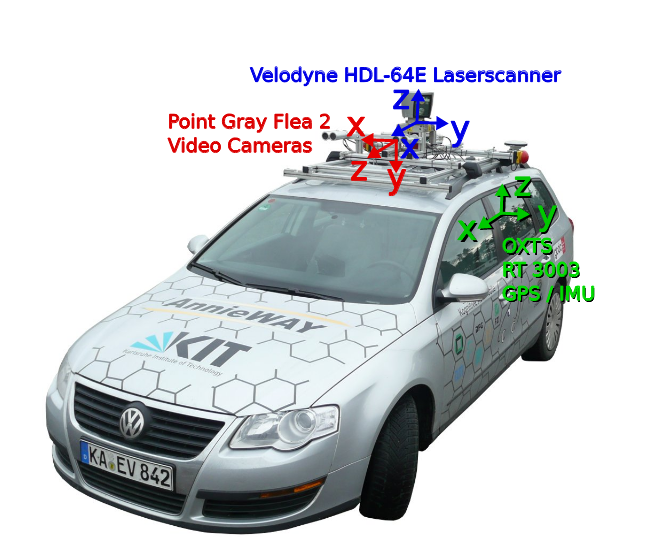

## **LiDAR to Camera**

In order to convert a point from the LiDAR to the camera image space, we must perform four transformations on the point. In this notebook we will transform all points to Camera 2 (the left RGB image), but these equations will allow quick substitution to translate points to any Camera.

The first transformation converts the point from the LiDAR to camera 0 frame of reference via rigid body transformation. NOTE: The camera frame of reference is a 3D point in the world with respect to the camera 0's location 0n the ego vehicle. A rigid transformation is essentially a rotation followed by a translation. A rigid transformation matrix can combine these two components like so:

$$
    T = \begin{bmatrix}
            r_{11} & r_{12} & r_{13} & t_{14} \\
            r_{21} & r_{22} & r_{23} & t_{24} \\
            r_{31} & r_{32} & r_{33} & t_{34}
        \end{bmatrix}
$$

Where the r's correspond to the 3x3 rotation matrix and the t's correspond to the 3x1 translation vector.

Next we perform another rigid transformation to go from Camera 0 to Camera 2 (or which ever camera we want to go to).

Next we perform the rectifying transformation, which is just a rotation. We need the rectifying transformtion since we are working the stereo images that are referenced to the same y-axis (i.e. an object on left image has the same y-coordinate as the right image, but not the necessarily the same x-coordinate). When a pair of stereo images are referenced to the same image plane (y-axis) we call them rectified.

Finally we apply the camera projection transformation. This gives us the location of a 3D point in 2D image space, which we denote as $(u, v)$ or $(u, v, z)$ if we have depth info.



In [13]:
with open('2011_10_03/calib_cam_to_cam.txt','r') as f:
    calib = f.readlines()

# get projection matrices (rectified left camera --> left camera (u,v,z))
P_rect2_cam2 = np.array([float(x) for x in calib[25].strip().split(' ')[1:]]).reshape((3,4))


# get rectified rotation matrices (left camera --> rectified left camera)
R_ref0_rect2 = np.array([float(x) for x in calib[24].strip().split(' ')[1:]]).reshape((3, 3,))

# add (0,0,0) translation and convert to homogeneous coordinates
R_ref0_rect2 = np.insert(R_ref0_rect2, 3, values=[0,0,0], axis=0)
R_ref0_rect2 = np.insert(R_ref0_rect2, 3, values=[0,0,0,1], axis=1)


# get rigid transformation from Camera 0 (ref) to Camera 2
R_2 = np.array([float(x) for x in calib[21].strip().split(' ')[1:]]).reshape((3,3))
t_2 = np.array([float(x) for x in calib[22].strip().split(' ')[1:]]).reshape((3,1))

# get cam0 to cam2 rigid body transformation in homogeneous coordinates
T_ref0_ref2 = np.insert(np.hstack((R_2, t_2)), 3, values=[0,0,0,1], axis=0)

## **Load LiDAR Calibration Data**

In [14]:
T_velo_ref0 = get_rigid_transformation(r'2011_10_03/calib_velo_to_cam.txt')
T_imu_velo = get_rigid_transformation(r'2011_10_03/calib_imu_to_velo.txt')

Obtain matrix to transform 3D LiDAR/velo (x, y, z) coordiantes to 2D camera (u,v) coordinates, and it's homogeneous inverse that will allow us to transform from camera (u, v, z, 1) back to LiDAR (x, y, z, 1)

In [15]:
# transform from velo (LiDAR) to left color camera (shape 3x4)
T_velo_cam2 = P_rect2_cam2 @ R_ref0_rect2 @ T_ref0_ref2 @ T_velo_ref0

# homogeneous transform from left color camera to velo (LiDAR) (shape: 4x4)
T_cam2_velo = np.linalg.inv(np.insert(T_velo_cam2, 3, values=[0,0,0,1], axis=0))

In [16]:
# transform from IMU to left color camera (shape 3x4)
T_imu_cam2 = T_velo_cam2 @ T_imu_velo

# homogeneous transform from left color camera to IMU (shape: 4x4)
T_cam2_imu = np.linalg.inv(np.insert(T_imu_cam2, 3, values=[0,0,0,1], axis=0))

Now that we are able to project the LiDAR points onto the image, we can associate points on the image with LiDAR depth. We will use YOLOv5 to detect objects in 2D, then we will find their corresponding depths.

<br>

## **Get Object Detection Pipeline**

In [14]:
!git clone https://github.com/ultralytics/yolov5

Cloning into 'yolov5'...
remote: Enumerating objects: 16582, done.
remote: Counting objects: 100% (60/60), done.
remote: Compressing objects: 100% (42/42), done.
remote: Total 16582 (delta 30), reused 39 (delta 18), pack-reused 16522
Receiving objects: 100% (16582/16582), 15.06 MiB | 14.97 MiB/s, done.
Resolving deltas: 100% (11389/11389), done.


In [15]:
!pip install -r yolov5/requirements.txt  #Install whatever is needed

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 4.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 14.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 756.5/756.5 kB 20.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 7.7 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_

In [1]:
import torch

model = torch.hub.load('ultralytics/yolov5', 'yolov5s')  # or yolov5m, yolov5l, yolov5x, custom

/usr/local/lib/python3.10/dist-packages/torch/hub.py:294: UserWarning: You are about to download and run code from an untrusted repository. In a future release, this won't be allowed. To add the repository to your trusted list, change the command to {calling_fn}(..., trust_repo=False) and a command prompt will appear asking for an explicit confirmation of trust, or load(..., trust_repo=True), which will assume that the prompt is to be answered with 'yes'. You can also use load(..., trust_repo='check') which will only prompt for confirmation if the repo is not already trusted. This will eventually be the default behaviour
  warnings.warn(
Downloading: "https://github.com/ultralytics/yolov5/zipball/master" to /root/.cache/torch/hub/master.zip
YOLOv5 🚀 2024-5-8 Python-3.10.12 torch-2.2.1+cu121 CPU

100%|██████████| 14.1M/14.1M [00:00<00:00, 43.8MB/s]

Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients, 16.4 GFLOPs
Adding AutoShape... 


In [2]:
# set confidence and IOU thresholds
model.conf = 0.7  # confidence threshold (0-1), default: 0.25
model.iou = 0.5  # NMS IoU threshold (0-1), default: 0.45

## **Detection Pipeline**

Now we can define the main pipeline to get the detections and their center coordinates in multiple reference frames. We will get the object centers in:
- Camera (u, v, z)
- LiDAR (x, y, z)


The basic pipeline is:

1. Detect objects in camera image
2. Project LiDAR point cloud to camera (u,v,z) coordinates
3. Associate object centers with projected (u,v,z) points

In [3]:
def get_uvz_centers(image, velo_uvz, bboxes, draw=True):
    ''' Obtains detected object centers projected to uvz camera coordinates.
        Starts by associating LiDAR uvz coordinates to detected object centers,
        once a match is found, the coordiantes are transformed to the uvz
        camera reference and added to the bboxes array.

        NOTE: The image is modified in place so there is no need to return it.

        Inputs:
          image - input image for detection
          velo_uvz - LiDAR coordinates projected to camera reference
          bboxes - xyxy bounding boxes form detections from yolov5 model output
          draw - (_Bool) draw measured depths on image
        Outputs:
          bboxes_out - modified array containing the object centers projected
                       to uvz image coordinates
        '''

    # unpack LiDAR camera coordinates
    u, v, z = velo_uvz

    # get new output
    bboxes_out = np.zeros((bboxes.shape[0], bboxes.shape[1] + 3))
    bboxes_out[:, :bboxes.shape[1]] = bboxes

    # iterate through all detected bounding boxes
    for i, bbox in enumerate(bboxes):
        pt1 = torch.round(bbox[0:2]).to(torch.int).numpy()
        pt2 = torch.round(bbox[2:4]).to(torch.int).numpy()

        # get center location of the object on the image
        obj_x_center = (pt1[1] + pt2[1]) / 2
        obj_y_center = (pt1[0] + pt2[0]) / 2

        # now get the closest LiDAR points to the center
        center_delta = np.abs(np.array((v, u))
                              - np.array([[obj_x_center, obj_y_center]]).T)

        # choose coordinate pair with the smallest L2 norm
        min_loc = np.argmin(np.linalg.norm(center_delta, axis=0))

        # get LiDAR location in image/camera space
        velo_depth = z[min_loc]; # LiDAR depth in camera space
        uvz_location = np.array([u[min_loc], v[min_loc], velo_depth])

        # add velo projections (u, v, z) to bboxes_out
        bboxes_out[i, -3:] = uvz_location

        # draw depth on image at center of each bounding box
        # This is depth as perceived by the camera
        if draw:
            object_center = (np.round(obj_y_center).astype(int),
                             np.round(obj_x_center).astype(int))
            cv2.putText(image,
                        '{0:.2f} m'.format(velo_depth),
                        object_center, # top left
                        cv2.FONT_HERSHEY_SIMPLEX,
                        0.5, # font scale
                        (255, 0, 0), 2, cv2.LINE_AA)

    return bboxes_out


In [4]:
def get_detection_coordinates(image, bin_path, draw_boxes=True, draw_depth=True):
    ''' Obtains detections for the input image, along with the coordinates of
        the detected object centers. The coordinate obtained are:
            - Camera with depth --> uvz
            - LiDAR/velo --> xyz
            - GPS/IMU --> xyz
        Inputs:
            image - rgb image to run detection on
            bin_path - path to LiDAR bin file
        Output:
            bboxes - array of detected bounding boxes, confidences, classes,
            velo_uv - LiDAR points porjected to camera uvz coordinate frame
            coordinates - array of all object center coordinates in the frames
                          listed above
        '''
    ## 1. compute detections in the left image
    detections = model(image)

    # draw boxes on image
    if draw_boxes:
        detections.show()

    # get bounding box locations (x1,y1), (x2,y2) Prob, class
    bboxes = detections.xyxy[0].cpu() # remove from GPU

    # get LiDAR points and transform them to image/camera space
    velo_uvz = project_velobin2uvz(bin_path,
                                   T_velo_cam2,
                                   image,
                                   remove_plane=True)

    # get uvz centers for detected objects
    bboxes = get_uvz_centers(image,
                             velo_uvz,
                             bboxes,
                             draw=draw_depth)

    return bboxes, velo_uvz

In [5]:
!pip install pymap3d

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.6/60.6 kB 1.8 MB/s eta 0:00:00


In [6]:
import pymap3d as pm


def imu2geodetic(x, y, z, lat0, lon0, alt0, heading0):
    ''' Converts cartesian IMU coordinates to Geodetic based on current
        location. This function works with x,y,z as vectors and lat0, lon0,
        alt0 as scalars.

        - Correct orientation is provided by the heading
        - The Elevation must be corrected for pymap3d (i.e. 180 is 0 elevation)
        Inputs:
            x - IMU x-coodinate (either scaler of (Nx1) array)
            y - IMU y-coodinate (either scaler of (Nx1) array)
            z - IMU z-coodinate (either scaler of (Nx1) array)
            lat0 - initial Latitude in degrees
            lon0 - initial Longitude in degrees
            alt0 - initial Ellipsoidal Altitude in meters
            heading0 - initial heading in radians (0 - East, positive CCW)
        Outputs:
            lla - (Nx3) numpy array of
        '''
    # convert to RAE
    rng = np.sqrt(x**2 + y**2 + z**2)
    az = np.degrees(np.arctan2(y, x)) + np.degrees(heading0)
    el = np.degrees(np.arctan2(np.sqrt(x**2 + y**2), z)) + 90

    # convert to geodetic
    lla = pm.aer2geodetic(az, el, rng, lat0, lon0, alt0)

    # convert to numpy array
    lla = np.vstack((lla[0], lla[1], lla[2])).T

    return lla

## **Test the pipeline**

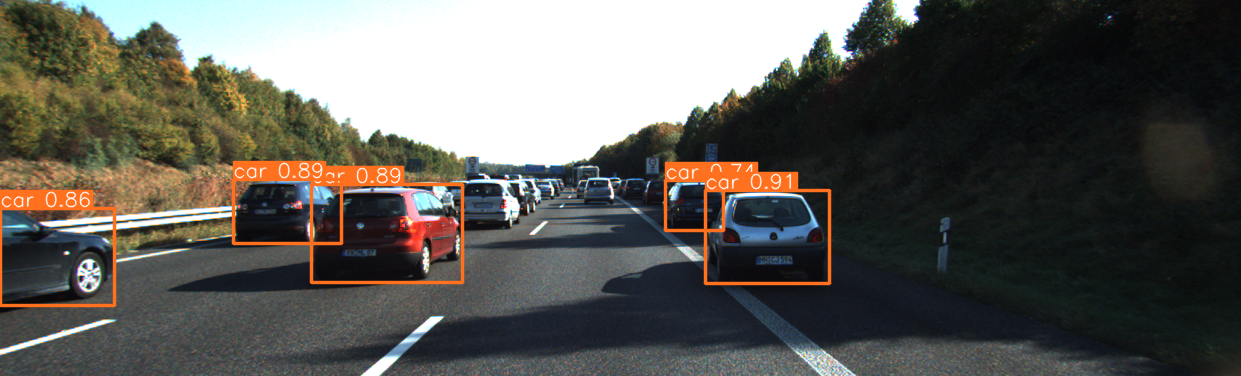

In [17]:
import cv2
index = 10

left_image = cv2.cvtColor(cv2.imread(left_image_paths[index]), cv2.COLOR_BGR2RGB)
bin_path = bin_paths[index]
oxts_frame = get_oxts(oxts_paths[index])

# get detections and object centers in uvz
bboxes, velo_uvz = get_detection_coordinates(left_image, bin_path)

# get transformed coordinates of object centers
uvz = bboxes[:, -3:]

# transform to (u,v,z)
# velo_xyz = transform_uvz(uvz, T_cam2_velo) # we can also get LiDAR coordiantes
imu_xyz = transform_uvz(uvz, T_cam2_imu)

# get Lat/Lon on each detected object
lat0 = oxts_frame[0]
lon0 = oxts_frame[1]
alt0 = oxts_frame[2]
heading0 = oxts_frame[5]

lla = imu2geodetic(imu_xyz[:, 0], imu_xyz[:, 1], imu_xyz[:, 2], lat0, lon0, alt0, heading0)

In [18]:
velo_image = draw_velo_on_image(velo_uvz, np.zeros_like(left_image))

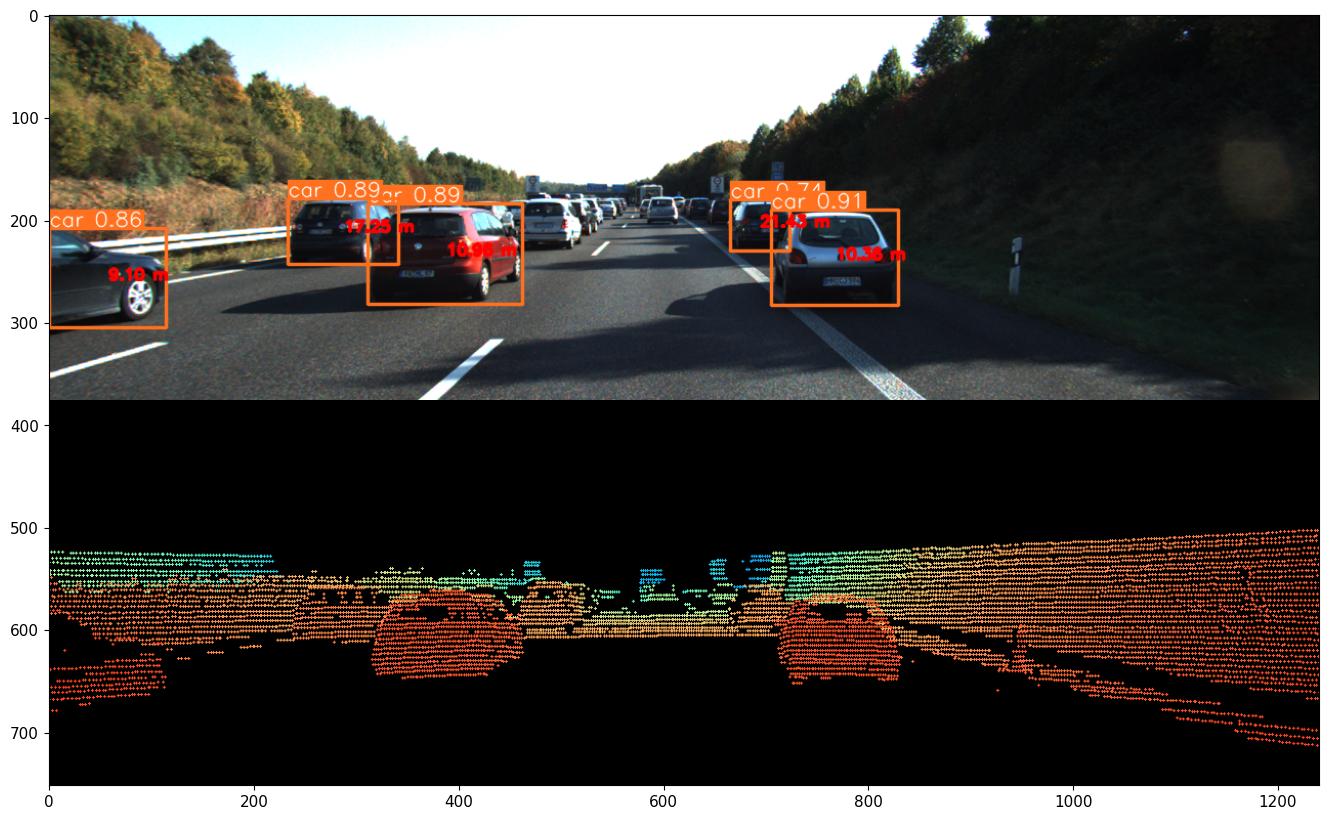

In [19]:
# pymap3d seems to mess with matplotlib in colab
%matplotlib inline
plt.rcParams["figure.figsize"] = (20, 10)

# stack image with LiDAR point cloud
stacked = np.vstack((left_image, velo_image))

# display stacked iamge
plt.imshow(stacked);

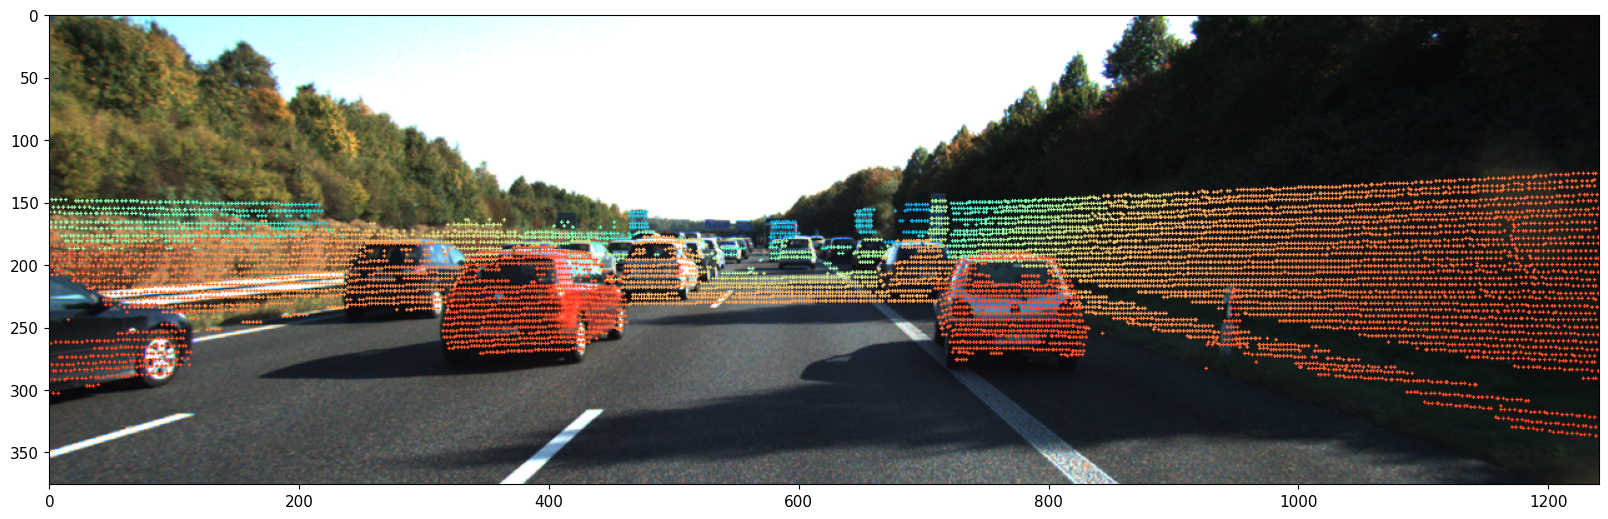

In [20]:
left_image_2 = cv2.cvtColor(cv2.imread(left_image_paths[index]), cv2.COLOR_BGR2RGB)
velo_image_2 = draw_velo_on_image(velo_uvz, left_image_2)

plt.imshow(velo_image_2);